# 2 toy datasets to discover pytorch 

This notebook will takes you through the step of creating and training a very simple neural network with pytorch in order to solve a simple binary classification task.

It presumes that the user is already familiar with the theoretical concepts of deep-learning and instead focuses on their implementation in pytorch.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import pytorch_model_summary as pms 

from torch.utils.data import TensorDataset, DataLoader,random_split

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


number of points: 400
categories: [0 1]


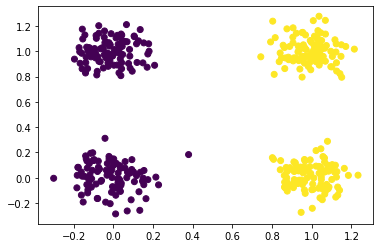

In [2]:
## Non linearly separable data : the infamous Xor problem
N = 10**2
blob_X = np.concatenate( [np.random.randn(N,2)*0.1 + np.array([0,0]),
                     np.random.randn(N,2)*0.1 + np.array([0,1]),
                     np.random.randn(N,2)*0.1 + np.array([1,1]),
                     np.random.randn(N,2)*0.1 + np.array([1,0])
                    ])

blob_y = np.array( [0]*N + [0]*N + [1]*N + [1]*N )

## shuffling, for good measure:
indexes = np.arange(blob_y.shape[0])
rng = np.random.default_rng()
rng.shuffle(indexes)

blob_X = blob_X[indexes,:]
blob_y = blob_y[indexes]


print('number of points:',len(blob_y))
print('categories:',np.unique(blob_y))
plt.scatter( blob_X[:,0],blob_X[:,1],c=blob_y )

## preparing the data

In [3]:
# transform to torch tensor
tensor_X = torch.Tensor(blob_X) 
tensor_y = torch.Tensor(blob_y)

# create your dataset
full_dataset = TensorDataset(tensor_X,tensor_y) 

# split between train and validation datasets
train_dataset, valid_dataset = random_split(full_dataset , [320,80] )

In [4]:
train_dataset

In [5]:
len( train_dataset ) , len( valid_dataset )

(320, 80)

In [6]:
train_dataset[0]

(tensor([0.0833, 0.9614]), tensor(0.))

In [7]:
## creating a dataloader
##   -> wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling 
##           and multiprocess data loading. 
##  not 100% needed here, but better to adopt best practices early on

train_dataloader = DataLoader(train_dataset , batch_size = 32 ) 
valid_dataloader = DataLoader(valid_dataset , batch_size = 32 ) 

In [8]:
train_dataloader

In [9]:
len( train_dataloader ) , train_dataloader.batch_size

(10, 32)

In [10]:
next( iter( train_dataloader ) )

[tensor([[ 0.0833,  0.9614],
         [ 1.0532, -0.1730],
         [-0.0158, -0.2045],
         [ 0.0309,  1.0202],
         [-0.1432,  1.1285],
         [ 1.0828, -0.0864],
         [ 1.0480,  0.0065],
         [ 0.0200,  0.8909],
         [ 0.0224,  1.0126],
         [-0.1835, -0.0792],
         [-0.1332, -0.0541],
         [ 0.0353,  0.0739],
         [ 0.1364,  0.0438],
         [-0.1787,  0.0826],
         [ 0.9617,  0.0878],
         [ 0.0938,  0.1434],
         [ 0.8888,  1.0378],
         [ 1.0465, -0.0529],
         [-0.0139,  0.0474],
         [ 0.9290, -0.0286],
         [ 0.9989,  0.9856],
         [ 0.0139,  1.1051],
         [ 1.0868, -0.0728],
         [-0.1092, -0.0079],
         [ 1.0366,  1.2763],
         [ 0.0304,  0.9842],
         [-0.0869,  1.1243],
         [ 0.8628, -0.0738],
         [ 1.0686,  1.2439],
         [ 0.9741,  0.9590],
         [-0.1210,  0.1121],
         [ 0.0849,  0.8660]]),
 tensor([0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0

## shallow model

<img src="images/shallow_LR.png" alt="a neural network with no hidden layer" style="width: 500px;"/>

In [11]:
# Logistic regression as a Pytorch module
class LR_neuralNet(torch.nn.Module):
    
    def __init__(self , input_dim = 2):
        super().__init__()
        self.layers = nn.Sequential( nn.Linear(input_dim, 1),          # Linear layer
                                     nn.Sigmoid()  # Non-linear activation
                                   )
        
        
    def forward(self, x):  # Forward pass
        proba = self.layers(x) 
        ## NB: here, the input  of the Sigmoid layer are logits
        ##           the output of the Sigmoid layer are probas
        return proba


model = LR_neuralNet( input_dim = 2 ).to(device)
print(model)

LR_neuralNet(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [13]:
print(pms.summary(model , torch.zeros(1,2).to(device), show_input=True) )

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Linear-1              [1, 2]               3               3
         Sigmoid-2              [1, 1]               0               0
Total params: 3
Trainable params: 3
Non-trainable params: 0
-----------------------------------------------------------------------


## preparing training, evaluating, ...

### making a prediction and computing loss

In [14]:

model.eval()
x, y = valid_dataset[0]

with torch.no_grad(): ## disables tracking of gradient: prevent accidental training + speeds up computation
    x = x.to(device)
    pred = model(x)
    predicted, actual = pred[0], y
    print(f'Predicted proba: "{predicted}", Actual: "{actual}"')

Predicted proba: "0.31729090213775635", Actual: "0.0"


In [15]:
pred

tensor([0.3173], device='cuda:0')

In [18]:
pred.to('cpu')

tensor([0.3173])

In [34]:
pred_cpu = pred.to("cpu")

In [35]:
((pred_cpu>0.5).numpy() == y.numpy()).sum()

1

In [60]:
(pred>0.5).float() == y.unsqueeze(1)

tensor([[ True],
        [ True],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [False],
        [ True]], device='cuda:0')

> Without the Sigmoid layer what we would get here would be logits, which is often the case and actually expected by some loss functions

In [37]:
## we will evaluate the prediction with the Binary Cross Entropy loss
## https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#toc-entry-1
##
##  BCE = - (y*log(p) + (1-y)*log(1-p))

loss = nn.BCELoss()(pred, y.unsqueeze(0).to(device)) # with BCE loss, we need to unsqueeze our target

# equivalent to : - np.log(pred)
loss

tensor(0.3817, device='cuda:0')

In [42]:
## in practice this happens at the scale of a batch :
x, y = next(iter(valid_dataloader))

with torch.no_grad(): 
    x = x.to(device)
    y = y.to(device)
    pred = model(x)
    print( f'loss: {nn.BCELoss()(pred, y.unsqueeze(1)).item():>7f}' )
    print( f"number of correct predictions: {((pred.to('cpu')>0.5).numpy() == y.to('cpu').numpy()).sum()}")

loss: 0.760973
number of correct predictions: 512


### defining training/validation functions

In [43]:
def train(dataloader, model, loss_fn, optimizer , echo = True):
    
    size = len(dataloader.dataset) # how many batches do we have
    model.train() #     Sets the module in training mode.
    
    for batch, (X, y) in enumerate(dataloader): # for each batch
        X, y = X.to(device), y.to(device) # send the data to the GPU or whatever device you use for training

        # Compute prediction error
        pred = model(X)              # prediction for the model -> forward pass
        loss = loss_fn(pred.squeeze(), y)      # loss function from these prediction

        # Backpropagation
        loss.backward()              # backward propagation 
        #                            https://ml-cheatsheet.readthedocs.io/en/latest/backpropagation.html
        #                            https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html
        
        optimizer.step()             
        optimizer.zero_grad()        # reset the gradients
                                     # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch

        if echo:
            current =  (batch + 1) * len(X)
            print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")
    
    # return the last batch loss:
    return loss.item()

In [61]:
def valid(dataloader, model, loss_fn, echo = True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() #     Sets the module in evaluation mode
    valid_loss, correct = 0, 0
    with torch.no_grad(): ## disables tracking of gradient: prevent accidental training + speeds up computation
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            valid_loss += loss_fn(pred, y.unsqueeze(1)).item()  ## accumulating the loss function over the batches
            
            correct += ((pred>0.5).float() == y.unsqueeze(1)).float().sum().item() ## counting number of true predictions
            
    valid_loss /= num_batches
    correct /= size
    if echo:
        print(f"Valid Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {valid_loss:>8f} \n")
    ## return the average loss / batch
    return valid_loss


 ### actual training

In [62]:
# list of loss functions https://pytorch.org/docs/stable/nn.html#loss-functions
# https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#toc-entry-1
loss_fn = nn.BCELoss()

# optimizer https://pytorch.org/docs/stable/optim.html
# https://ml-cheatsheet.readthedocs.io/en/latest/optimizers.html#sgd
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1) 

In [63]:
%%time

epochs = 5
train_losses = []
valid_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_losses.append( train(train_dataloader, model, loss_fn, optimizer, echo=True) )
    valid_losses.append( valid(valid_dataloader, model, loss_fn) )
print("Done!")

Epoch 1
-------------------------------
loss: 0.510006  [   32/  320]
loss: 0.502563  [   64/  320]
loss: 0.529538  [   96/  320]
loss: 0.494491  [  128/  320]
loss: 0.484932  [  160/  320]
loss: 0.478654  [  192/  320]
loss: 0.479905  [  224/  320]
loss: 0.501253  [  256/  320]
loss: 0.502345  [  288/  320]
loss: 0.468843  [  320/  320]
Valid Error: 
 Accuracy: 100.0%, Avg loss: 0.478264 

Epoch 2
-------------------------------
loss: 0.480475  [   32/  320]
loss: 0.466715  [   64/  320]
loss: 0.498620  [   96/  320]
loss: 0.460711  [  128/  320]
loss: 0.451704  [  160/  320]
loss: 0.446799  [  192/  320]
loss: 0.451489  [  224/  320]
loss: 0.471771  [  256/  320]
loss: 0.475142  [  288/  320]
loss: 0.441534  [  320/  320]
Valid Error: 
 Accuracy: 100.0%, Avg loss: 0.449128 

Epoch 3
-------------------------------
loss: 0.453710  [   32/  320]
loss: 0.436491  [   64/  320]
loss: 0.471881  [   96/  320]
loss: 0.432200  [  128/  320]
loss: 0.423278  [  160/  320]
loss: 0.419443  [  192

In [64]:
#from there we can continue training a bit
train_losses.append( train(train_dataloader, model, loss_fn, optimizer, echo=False) )
valid_losses.append( valid(valid_dataloader, model, loss_fn) )


Valid Error: 
 Accuracy: 100.0%, Avg loss: 0.361673 



Text(0, 0.5, 'cross-entropy loss')

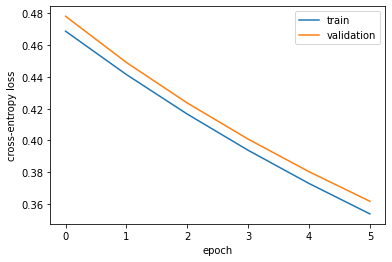

In [65]:
plt.plot(train_losses , label = 'train')
plt.plot(valid_losses, label = 'validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('cross-entropy loss')

## Non linearly separable data : the infamous Xor problem


number of points: 400
categories: [0 1]


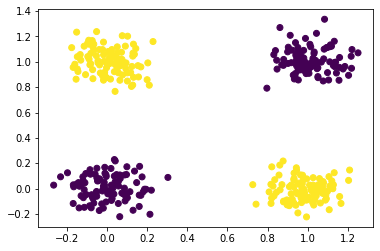

In [66]:
N = 10**2
xor_X = np.concatenate( [np.random.randn(N,2)*0.1 + np.array([0,0]),
                     np.random.randn(N,2)*0.1 + np.array([1,1]),
                     np.random.randn(N,2)*0.1 + np.array([1,0]),
                     np.random.randn(N,2)*0.1 + np.array([0,1])
                    ])

xor_y = np.array( [0]*N + [0]*N + [1]*N + [1]*N )

## shuffling, for good measure:
indexes = np.arange(xor_y.shape[0])
rng = np.random.default_rng()
rng.shuffle(indexes)

xor_X = xor_X[indexes,:]
xor_y = xor_y[indexes]


print('number of points:',len(xor_y))
print('categories:',np.unique(xor_y))
plt.scatter( xor_X[:,0],xor_X[:,1],c=xor_y )

In [68]:
# transform to torch tensor
tensor_X = torch.Tensor(xor_X) 
tensor_y = torch.Tensor(xor_y)

# create your dataset
full_dataset = TensorDataset(tensor_X,tensor_y)

# split between train and validation datasets
train_dataset, valid_dataset = random_split(full_dataset , [320,80] )


## creating a dataloader
train_dataloader = DataLoader(train_dataset , batch_size = 32 ) 
valid_dataloader = DataLoader(valid_dataset , batch_size = 32 ) 

In [69]:
model = LR_neuralNet( input_dim = 2 ).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1) 

In [70]:
%%time

epochs = 50
train_losses = []
valid_losses = []

print("before training:")
valid(valid_dataloader, model, loss_fn , echo = True)

for t in range(epochs):
    train_losses.append( train(train_dataloader, model, loss_fn, optimizer, echo=False) )
    valid_losses.append( valid(valid_dataloader, model, loss_fn , echo = False) )
print("Done!")
print("after training:")
valid(valid_dataloader, model, loss_fn , echo = True)


before training:
Valid Error: 
 Accuracy: 72.5%, Avg loss: 0.697860 

Done!
after training:
Valid Error: 
 Accuracy: 68.8%, Avg loss: 0.697795 

CPU times: user 461 ms, sys: 4.01 ms, total: 465 ms
Wall time: 466 ms


0.6977950731913248

Text(0, 0.5, 'cross-entropy loss')

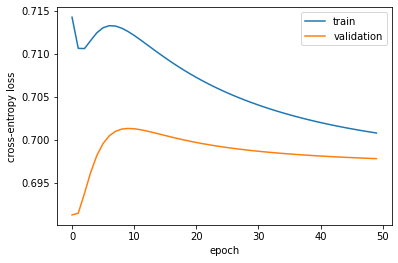

In [71]:
plt.plot(train_losses , label = 'train')
plt.plot(valid_losses, label = 'validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('cross-entropy loss')

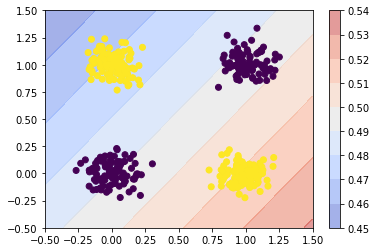

In [74]:
fig,ax = plt.subplots()

xx, yy = np.meshgrid(np.linspace(-0.5,1.5,100),np.linspace(-0.5,1.5,100))

pred = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device)).to("cpu").detach().numpy()
Z = pred.reshape(xx.shape)


CS = ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.5)
cbar = plt.colorbar(CS, ax=ax)

ax.scatter(xor_X[:,0],xor_X[:,1],c=xor_y)

We need something more complex.

## Hands-on : from shallow to deep learning

<img src="images/deep_LR.png" alt="a neural network with 1 hidden layer" style="width: 500px;"/>

Adapt the code below to add an additional layer:

 - make this layer of size 3 (ie, it is made of 3 neurons)
 - add a ReLU activation to this layer

Instanciate this model, and then train it on the xor data

**important info:**
 
 - relu layer class: `nn.ReLU`. Like the Sigmoid activation, they do not take any argument on creation
 - you will likely need to train for at least 100 epoch
 - use the following optimizer `optimizer = torch.optim.SGD(model.parameters(), lr=0.1,momentum=0.9) `
 - it may happen that your optimization fails for stochastic reasons. Do not hesitate to re-create and re-train your model a couple of times if that happens.




In [75]:

class deepLR_neuralNet(torch.nn.Module):
    
    def __init__(self , input_dim = 2):
        super().__init__()
        self.layers = nn.Sequential( nn.Linear(input_dim, 1),          # Linear layer
                                     nn.Sigmoid()  # Non-linear activation
                                   )
        
        
    def forward(self, x):  # Forward pass
        proba = self.layers(x) 
        ## NB: here, the input  of the Sigmoid layer are logits
        ##           the output of the Sigmoid layer are probas
        return proba


model = LR_neuralNet( input_dim = 2 ).to(device)
print(model)

LR_neuralNet(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


### correction

Define the model

In [68]:
# %load -r 1-18 solutions/XOR_NN.py

check model input/output

In [67]:
# %load -r 19 solutions/XOR_NN.py

define loss and optimizer

In [66]:
# %load -r 20-22 solutions/XOR_NN.py

train

In [65]:
# %load -r 23-37 solutions/XOR_NN.py

We can have a look at the latent space represented in the hidden layer.

In [64]:
# %load -r 38-50 solutions/XOR_NN.py

In [63]:
# %load -r 51- solutions/XOR_NN.py

## Extra : hyper-parameters


**Question:** which hyper-parameters of our model can you identify?

Answer:

 - model architecture (number/type of layers, activation functions, layer size,...)
 - optimizer (optimizer itself + learning rate, momentum,...)
 - batch size
 - number of epochs


Hyper-parameters may be tuned using the classical tools of ML.

We present here an adaptation of the [Ray tune tutorial](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html) present on pytorch website, but other algorithms, such as those proposed in [sklearn](https://scikit-learn.org/stable/modules/grid_search.html), or with [hyperopt](http://hyperopt.github.io/hyperopt/), would work.

In [76]:
from functools import partial
from ray.air import Checkpoint, session
from ray import tune
from ray.tune.schedulers import ASHAScheduler

def train_LRdeep(config, train_dataloader, valid_dataloader):
    
    model = deepLR_neuralNet( input_dim = 2 , hidden_dim = 5 ).to(device)
    
    loss_fn = nn.BCELoss()
    
    optimizer = torch.optim.SGD(model.parameters(), 
                                lr=config['lr'] ,              # setup for hyper-param optimization
                                momentum = config['momentum']) # setup for hyper-param optimization

    epochs = 50

    for t in range(epochs):
        train_losses.append( train(train_dataloader, model, loss_fn, optimizer, echo=False) )
        valid_loss = valid(valid_dataloader, model, loss_fn , echo = False)
    
    
        session.report( {'loss':valid_loss} )
    


ModuleNotFoundError: No module named 'ray'

In [ ]:
%%time
config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    'momentum': tune.uniform(1e-3, 1-1e-3)
}

scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=100,
        grace_period=10,
        reduction_factor=2,
    )


result = tune.run(
    partial(train_LRdeep, 
            train_dataloader=train_dataloader ,
            valid_dataloader=valid_dataloader),
    resources_per_trial={"cpu": 4},
    config=config,
    num_samples=10,
    scheduler=scheduler,
    checkpoint_at_end=False)

## Extra : handling initialization to ease optimization

In [ ]:
## second correction: initialization reduces optimization problems
class deepLR_neuralNet(torch.nn.Module):
    
    def __init__(self , input_dim = 2 , hidden_dim=3):
        super().__init__()
        self.layers = nn.Sequential( nn.Linear(input_dim, hidden_dim),          # Linear layer
                                     nn.ReLU(),                                 # ReLU layer
                                     nn.Linear(hidden_dim, 1),                  # Linear layer
                                     nn.Sigmoid()  # Non-linear activation
                                   )
        nn.init.xavier_normal_(self.layers[0].weight, 
                                         gain=nn.init.calculate_gain('relu'))
        nn.init.xavier_normal_(self.layers[2].weight, 
                                         gain=nn.init.calculate_gain('sigmoid'))
    def forward(self, x):  # Forward pass
        proba = self.layers(x) 
        ## NB: here, the input  of the Sigmoid layer are logits
        ##           the output of the Sigmoid layer are probas
        return proba


model = deepLR_neuralNet( input_dim = 2 ).to(device)
print(model)